In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import pylab
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [7]:
def plot_cv_per_nb_nodes(df, algo):
    df_algo = df[df['algo'] == algo]
    std = df_algo.groupby('nb_nodes')['time'].std()
    mean = df_algo.groupby('nb_nodes')['time'].mean()
    cv = [s/m for s, m in zip(std, mean)]
    plt.plot(std.index, cv)
    plt.xlabel('nb_nodes')
    plt.ylabel('cv')
    plt.show()

def plot_std_per_nb_nodes(df, algo):
    df_algo = df[df['algo'] == algo]
    std = df_algo.groupby('nb_nodes')['time'].std()
    plt.plot(std.index, std.values)
    plt.xlabel('nb_nodes')
    plt.ylabel('std')
    plt.show()

def plot_mean_per_nb_nodes(df, algo):
    df_algo = df[df['algo'] == algo]
    mean = df_algo.groupby('nb_nodes')['time'].mean()
    plt.plot(mean.index, mean.values)
    plt.xlabel('nb_nodes')
    plt.ylabel('mean')
    plt.show()

def plot_data(x, y, x_label, y_label, fraction):
    i = round((1-fraction)*len(x))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x[i:], y[i:])
    pylab.show()

def plot_linear(x, y, x_label, y_label, fraction, a, b):
    i = round((1-fraction) * len(x))
    x, y = x[i:], y[i:]
    plot_line(a, b, x)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, y)
    pylab.show()

def plot_line(a, b, x):
    x = x.reset_index()['nb_nodes']
    x0, x1 = x[0], x[1]
    y0, y1 = a*x[0]+b, a*x[1]+b
    plt.plot([x0, x1], [y0, y1], '-.r', label=f'y={a}x+{b}')
    plt.show()

In [37]:
from math import factorial
def bb_upper_bound(n):
    smart_probable_lengths = [1.0]
    for i in range(1, n):
        total_prob = 0
        for j in range(0, i):
            total_prob += 0.1**j * stirling_fast(i, i-j)
        smart_probable_lengths.append(total_prob)
    t = 0
    for v in smart_probable_lengths:
        t+=v
    return t * n * math.log(n)


def binom(a,b):
    return factorial(a) / (factorial(b)*factorial(a-b))

def stirling_fast(n,k):
    if n<=0 or n!=0 and n==k:
        return 1
    elif k<=0 or n<k:
        return 0
    elif n==0 and k==0:
        return -1
    else:
        s = sum((-1)**(k-j)*binom(k,j)*j**n for j in range(k+1))
        return s / factorial(k)

def exp2_obj(x, a, b):
    return a * np.float_power(b, x)
#
# smart_probable_lengths = [1.0]
# n=10-1
#
# for i in range(1, n):
#     total_prob = 0
#     for j in range(0, i):
#         total_prob += 0.1**j * stirling_fast(i, i-j)
#     smart_probable_lengths.append(total_prob)
#
# print(smart_probable_lengths)

In [9]:
df = pd.read_csv('results.csv')
df_mean = df.groupby(['algo', 'nb_nodes']).mean().reset_index()

df_mean = df_mean.drop('seed', axis=1)
df_mean.to_csv('means.csv', index=False)

gl_df = df_mean[df_mean['algo'] == 'glouton']
bb_df = df_mean[df_mean['algo'] == 'branch_bound']
tabu_df = df_mean[df_mean['algo'] == 'tabu']

In [38]:
def plot_raw(df, fraction=1):
    plot_data(df['nb_nodes'], df['time'], 'Nb Noeuds', 'Temps', fraction)

def plot_ratio_test(df, estimated_complexity, fraction=1):
    x = df['nb_nodes']
    y = [t/estimated_complexity(n) for t, n in zip(df['time'], df['nb_nodes'])]
    i = round((1-fraction) * len(x))
    x, y = list(x[i:]), list(y[i:])
    X = np.array([np.array([e]) for e in x])
    y = np.array(y)
    print('Test du rapport')
    reg = LinearRegression()
    reg.fit(X, y)
    y_pred = reg.predict(X)
    b = reg.intercept_
    a = reg.coef_[0]
    print(a)
    print(f'score: {reg.score(X, y)}')
    print(f'a: {a}')
    print(f'b: {b}')
    print(f'y/f(x) = {b} * x')
    plt.scatter(x, y, color="black", s=1)
    plt.xlabel('Nb Noeuds')
    plt.ylabel('Rapport')
    plt.plot(x, y_pred, '-.r', linewidth=1)
    plt.show()

def plot_power_test(df, fraction=1):

    i = round((1-fraction) * len(df['nb_nodes']))
    x, y = list(df['nb_nodes'][i:]), list(df['time'][i:])
    a = 2
    log_x = list(map(lambda v: math.log(v, a), x))
    log_y = list(map(lambda v: math.log(v, a), y))

    log_X = np.array([np.array([e]) for e in log_x])
    log_y = np.array(log_y)
    print('Test puissance')
    reg = LinearRegression().fit(log_X, log_y)
    m = reg.coef_[0]
    b = reg.intercept_
    print(f'score: {reg.score(log_X, log_y)}')
    print(f'm: {m}')
    print(f'b: {b}')
    print(f'a: {a}')
    print(f'y = {pow(a, b)} * x^{m}')
    log_y_pred = reg.predict(log_X)
    y_pred = [a**e for e in log_y_pred]
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(x, y, color="black", s=1)
    plt.xlabel('Nb Noeuds')
    plt.ylabel('Temps')
    plt.plot(x, y_pred, '-.r', linewidth=1)
    plt.show()

def plot_exponent_test(df, fraction=1):
    i = round((1-fraction) * len(df['nb_nodes']))
    x, y = list(df['nb_nodes'][i:]), list(df['time'][i:])
    a = 2
    log_y = list(map(lambda v: math.log(v, a), y))

    X = np.array([np.array([e]) for e in x])
    log_y = np.array(log_y)
    print("Test d'exponentiation")
    reg = LinearRegression().fit(X, log_y)
    m = a**reg.intercept_
    b = a**reg.coef_[0]
    print(f'score: {reg.score(X, log_y)}')
    print(f'm: {m}')
    print(f'b: {b}')
    print(f'y = {m} * {b}^x')
    log_y_pred = reg.predict(X)
    y_pred = [a**e for e in log_y_pred]
    plt.yscale('log')
    plt.scatter(x, y, color="black", s=1)
    plt.xlabel('Nb Noeuds')
    plt.ylabel('Temps')
    plt.plot(x, y_pred, '-.r', linewidth=1)
    plt.show()

def plot_exponent2_test(df, fraction=1):
    i = round((1-fraction) * len(df['nb_nodes']))
    x, y = list(df['nb_nodes'][i:]), list(df['time'][i:])
    popt, pcov = curve_fit(exp2_obj, x, y)
    print("Test d'exponentiation 2")
    a, b = popt
    score = np.sqrt(np.diag(pcov))
    print(f'variance: {score}')
    print(f'a: {a}')
    print(f'b: {b}')
    print(f'y = {a}*{b}^x')
    y_pred = exp2_obj(x, *popt)
    plt.scatter(x, y, color="black", s=1)
    plt.xlabel('Nb Noeuds')
    plt.ylabel('Temps')
    plt.plot(x, y_pred, '-.r', linewidth=1)
    plt.show()

def plot_const_test(df, estimated_complexity, fraction=1):
    x = df['nb_nodes']
    y = df['time']
    i = round((1-fraction) * len(x))
    x, y = list(map(estimated_complexity, list(x[i:]))), list(y[i:])
    X = np.array([np.array([e]) for e in x])
    y = np.array(y)
    print('Test des constantes')
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    c = reg.coef_[0]
    b = reg.intercept_
    print(f'score: {reg.score(X, y)}')
    print(f'c: {c}')
    print(f'b: {b}')
    print(f'y = {c} * f(x) + {b}')
    plt.scatter(x, y, color="black", s=1)
    plt.xlabel('f(Nb Noeuds)')
    plt.ylabel('Temps')
    plt.plot(x, y_pred, '-.r', linewidth=1)
    plt.show()


Glouton
Test du rapport
-2.816924116092215e-09
score: 0.0031441996460624955
a: -2.816924116092215e-09
b: 9.07856014854371e-05
y/f(x) = 9.07856014854371e-05 * x


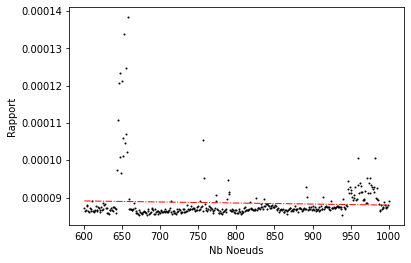

Test du rapport
5.684579452509084e-05
score: 0.010236039592439239
a: 5.684579452509084e-05
b: 0.9544530688236978
y/f(x) = 0.9544530688236978 * x


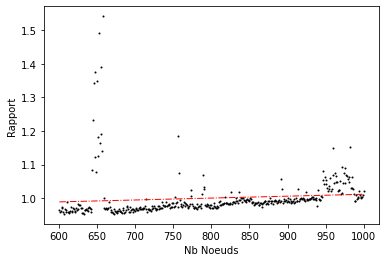

Test puissance
score: 0.9731885247109944
m: 2.0808183558780087
b: -11.50329579484284
a: 2
y = 0.00034447913088006527 * x^2.0808183558780087


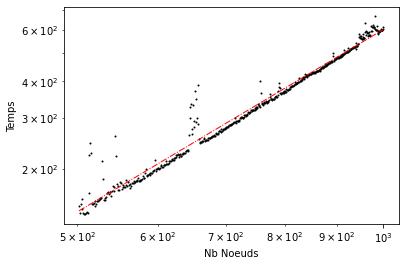

Test des constantes
score: 0.9807996731525098
c: 8.760437279101828e-05
b: 4.57454807876951
y = 8.760437279101828e-05 * f(x) + 4.57454807876951


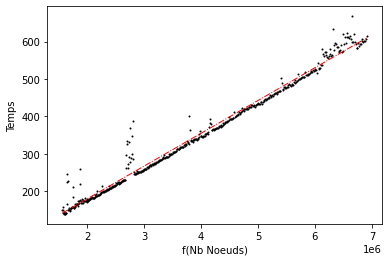

In [11]:
print('Glouton')
plot_ratio_test(gl_df, lambda n: n**2*math.log(n), 0.4)
plot_ratio_test(gl_df, lambda n: n**2.0808183558780087, 0.4)
plot_power_test(gl_df, 0.5)
plot_const_test(gl_df, lambda n: n**2*math.log(n), 0.5)

branch_bound
Test puissance
score: 0.7431479505892062
m: 4.0512103031774815
b: -14.922528501787827
a: 2
y = 3.220114465223568e-05 * x^4.0512103031774815


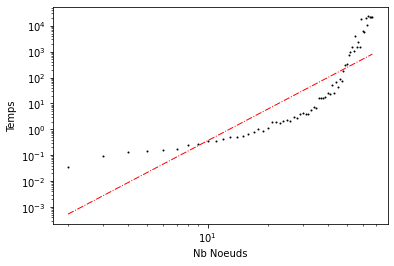

expo 1
Test d'exponentiation
score: 0.9595041991468628
m: 0.02339577952029096
b: 1.2170493824923394
y = 0.02339577952029096 * 1.2170493824923394^x


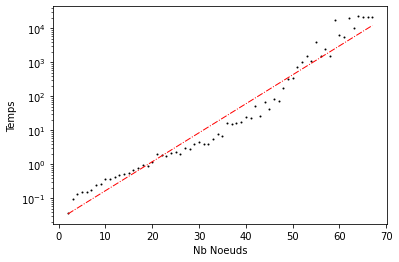

Test des constantes
score: 0.8469501199495555
c: 2.3375749274448925
b: 69.10545900890747
y = 2.3375749274448925 * f(x) + 69.10545900890747


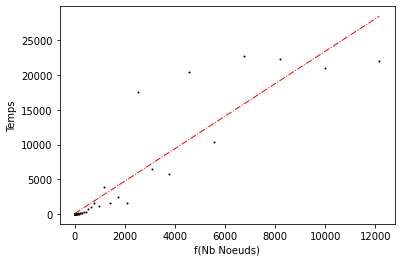

expo 2
Test d'exponentiation 2
variance: [0.50283801 0.01773378]
a: 0.5174299495502188
b: 1.175674374440339
y = 0.5174299495502188*1.175674374440339^x


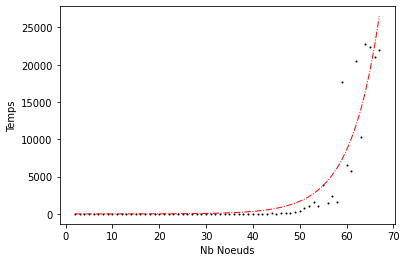

Test des constantes
score: 0.8603975964978963
c: 1.0174396241566088
b: -249.64419188163902
y = 1.0174396241566088 * f(x) + -249.64419188163902


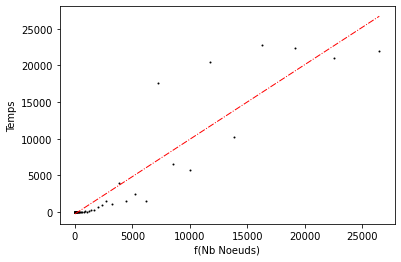

stirling
Test du rapport
-1.449431717846268e-14
score: 0.22759378417087794
a: -1.449431717846268e-14
b: 8.25507582741961e-13
y/f(x) = 8.25507582741961e-13 * x


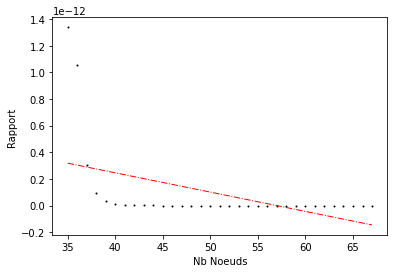

In [39]:

print('branch_bound')
plot_power_test(bb_df, 1)
print('expo 1')
plot_exponent_test(bb_df, 1)
plot_const_test(bb_df, lambda n: 0.02339577952029096 * 1.2170493824923394**n, 1)
print('expo 2')
plot_exponent2_test(bb_df, 1)
f = 1
i = round((1-f) * len(bb_df['nb_nodes']))
x, y = list(bb_df['nb_nodes'][i:]), list(bb_df['time'][i:])
popt, _ = curve_fit(exp2_obj, x, y)
plot_const_test(bb_df, lambda n: exp2_obj(n, *popt), f)
print('stirling')
plot_ratio_test(bb_df, bb_upper_bound, 0.5)

tabu
Test du rapport
2.668590686579903e-06
score: 0.0015931135128226526
a: 2.668590686579903e-06
b: 0.04674043277282196
y/f(x) = 0.04674043277282196 * x


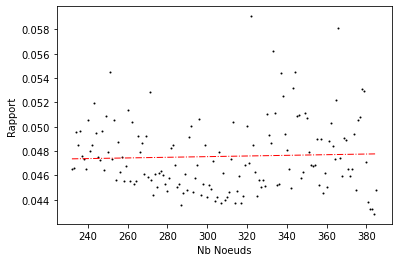

Test du rapport
0.00013700511826966993
score: 0.13897998234963038
a: 0.00013700511826966993
b: 0.19948484060272512
y/f(x) = 0.19948484060272512 * x


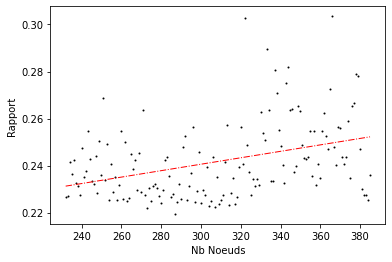

Test puissance
score: 0.9704689182333208
m: 2.0206772441918917
b: -2.0397160736082967
a: 2
y = 0.2432115968613044 * x^2.0206772441918917


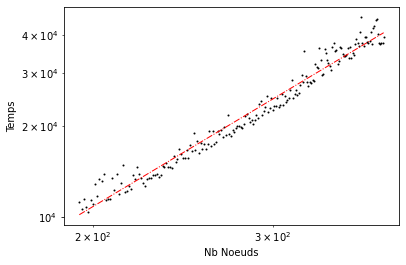

Test des constantes
score: 0.9637842034530746
c: 0.046530712639390355
b: 762.3089397958684
y = 0.046530712639390355 * f(x) + 762.3089397958684


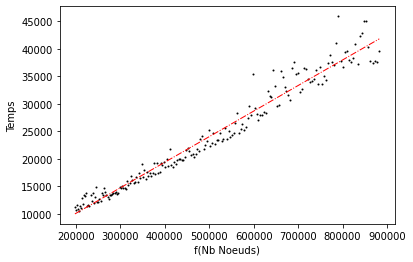

In [40]:
print('tabu')
plot_ratio_test(tabu_df, lambda n: n**2*math.log(n), 0.4)
plot_ratio_test(tabu_df, lambda n: n**2.0206772441918917, 0.4)
plot_power_test(tabu_df, 0.5)
plot_const_test(tabu_df, lambda n: n**2*math.log(n), 0.5)

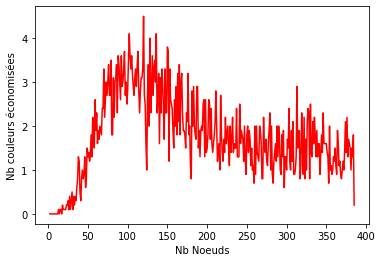

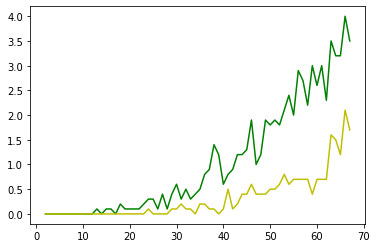

In [14]:
y_column = 'ans'
x1, y1 = list(gl_df['nb_nodes']), list(gl_df[y_column])
x2, y2 = list(bb_df['nb_nodes']), list(bb_df[y_column])
x3, y3 = list(tabu_df['nb_nodes']), list(tabu_df[y_column])
plt.xlabel('Nb Noeuds')
plt.ylabel('Nb couleurs économisées')
diff_1_3 = np.subtract(y1[:len(x3)], y3)
diff_1_2 = np.subtract(y1[:len(x2)], y2)
diff_3_2 = np.subtract(y3[:len(x2)], y2)
plt.plot(x3, diff_1_3, 'r')
pylab.show()
plt.plot(x2, diff_1_2, 'g')
plt.plot(x2, diff_3_2, 'y')
pylab.show()